# Data exploration &  pré-processing

In [1]:
import pandas as pd
import numpy as np

## Petits tests

In [12]:
s1_pickle = pd.read_pickle("./src/model/data/S1/S1.pkl")
s1_keys = s1_pickle.keys()

L'id du sujet

In [3]:
s1_pickle['subject']

'S2'

Fréquence cardiaque grâce à l'électrocardiographie (ECG)

In [4]:
s1_pickle['rpeaks']

array([     33,     700,    1316, ..., 5742473, 5742909, 5743349],
      dtype=int32)

Contient toutes les données enregistrer par RespiBAN (torse) et Empatica E4 (poignet)

Chaque donnée est descrite dans le fichier info.txt de chaque dossier patient

In [15]:
s1_pickle['signal']

{'chest': {'ACC': array([[ 0.91139996,  0.03219998,  0.051     ],
         [ 0.91120005,  0.03240001,  0.04900002],
         [ 0.90900004,  0.03460002,  0.04579997],
         ...,
         [ 0.91659999,  0.02900004, -0.04180002],
         [ 0.91719997,  0.03120005, -0.04220003],
         [ 0.91620004,  0.03120005, -0.03920001]]),
  'ECG': array([[-0.02503967],
         [-0.02778625],
         [-0.03515625],
         ...,
         [ 0.06454468],
         [ 0.06646729],
         [ 0.07122803]]),
  'EMG': array([[-1.5],
         [-1.5],
         [-1.5],
         ...,
         [-1.5],
         [-1.5],
         [-1.5]]),
  'EDA': array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
  'Temp': array([[-273.15],
         [-273.15],
         [-273.15],
         ...,
         [-273.15],
         [-273.15],
         [-273.15]], dtype=float32),
  'Resp': array([[-3.0380249 ],
         [-3.04412842],
         [-3.07006836],
         ...,
         [

Moyenne de la fréquence cardiaque

In [4]:
s1_pickle['label']

array([70.9229657 , 71.29105528, 68.69383264, ..., 95.13817648,
       96.7405001 , 96.84438537])

In [5]:
s1_pickle['activity']

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

Information sur la personne

In [22]:
s1_pickle['questionnaire']


{'WEIGHT': 78.0,
 'Gender': ' m',
 'AGE': 34,
 'HEIGHT': 182.0,
 'SKIN': 3,
 'SPORT': 6}

In [16]:
for signal in s1_pickle['signal']['chest']:
     print(signal)

ACC
ECG
EMG
EDA
Temp
Resp


Les signaux à analyser sont ACC (wrist & chest), ECG (chest), RESP (chest) ET BVP (wrist) 

In [ ]:
s1_pickle['signal']['wrist']['ACC'][0]


## Pré-traitement

In [11]:
def split_data(data, value):
        splited = np.split(data, value)
        temp = list()
        for i in splited:
            temp.append(np.mean(i))
        return temp

def scaling_data(signal, frequence):
    scale_step = int(frequence / 4)
    
    scaled_signal = list()
    for i in range(0, len(signal), scale_step):
        sum_scale_signal = sum(signal[i : i + scale_step]) / scale_step
        scaled_signal.append(sum_scale_signal)
        
    return scaled_signal

"""
Supprime les signaux inutiles
on fait une copie pour garder les données du patient
"""

def remove_useless_data(patient):
    # on supprime les données inutiles
    copy_patient = patient
    del copy_patient['subject']
    del copy_patient['signal']['chest']['EDA']
    del copy_patient['signal']['chest']['EMG']
    del copy_patient['signal']['chest']['Temp']
    del copy_patient['signal']['wrist']['EDA']
    
    return copy_patient

def hot_encoding_gender(patient):
    return 0 if patient['questionnaire']['Gender'] == 'm' else 1

"""
Retourne un dataframe traité provenant des données patients

:parameter:
patient (dict): donnée patient (fichier pkl)

:returns:
DataFrame: Données patient traitées
"""
def pretreatment(patient):
    patient = remove_useless_data(patient)
    
    rpeak = [0] * len(patient["signal"]["chest"]["ACC"])  
    for i in patient['rpeaks']:
        rpeak[i - 1] = 1
    label = np.repeat(patient['label'], 8)
    
    diff = len(patient["activity"]) - len(label)
    for i in range(diff):
        label = np.append(label, label[-1])
    del patient['rpeaks']    
    patient['label'] = split_data(label, len(patient['activity']))
    patient['rpeak'] = split_data(np.asarray(rpeak), len(patient['activity'])) 
    # Données torses RespiBan : ACC ECG et Resp sont à 700Hz
    # On renome les clés pour y accéder plus facilement
    patient["signal_chest_ACC"] = scaling_data(patient["signal"]["chest"]["ACC"], 700)
    patient["signal_chest_ECG"] = scaling_data(patient["signal"]["chest"]["ECG"], 700)
    patient["signal_chest_Resp"] = scaling_data(patient["signal"]["chest"]["Resp"], 700)

    # Données Poignet : ACC à 32Hz et BVP à 64Hz
    # Même traitement que pour les données torses
    patient["signal_wrist_ACC"] = scaling_data(patient["signal"]["wrist"]["ACC"], 32)
    patient["signal_wrist_BVP"] = scaling_data(patient["signal"]["wrist"]["BVP"], 64)
    
    del patient['signal']
    
    patient['questionnaire']['Gender'] = hot_encoding_gender(patient)
    for key, value in patient['questionnaire'].items():
        patient[key] = [value] * len(patient["signal_wrist_BVP"])
    del patient['questionnaire']
    
    patient['activity'] = patient['activity'].tolist()
    return pd.DataFrame.from_dict(patient)

In [13]:
s1_df = pretreatment(s1_pickle)
del s1_pickle

Maintenant il faut le faire pour chacun des patients et tout regrouper

In [14]:
full_df = pd.DataFrame()
full_df = full_df.append(s1_df)
del s1_df

In [15]:
full_df

,label,activity,rpeak,signal_chest_ACC,signal_chest_ECG,signal_chest_Resp,signal_wrist_ACC,signal_wrist_BVP,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT
0,49.611369,[0.0],0.000000,"[0.8521565743855067, -0.06648799930300031, -0....",[0.035650111607142855],[4.834437779017857],"[-0.763671875, -0.076171875, 0.669921875]",[0.13812500000000016],78.0,1,34,182.0,3,6
1,49.611369,[0.0],0.005714,"[0.8512617124829973, -0.06665485620498657, -0....",[0.1031451416015625],[4.238839285714286],"[-0.763671875, -0.078125, 0.671875]",[-26.2625],78.0,1,34,182.0,3,6
2,49.611369,[0.0],0.000000,"[0.8515702833448138, -0.06467657225472587, -0....",[0.09910112653459821],[2.058558872767857],"[-0.76171875, -0.078125, 0.671875]",[-40.959374999999994],78.0,1,34,182.0,3,6
3,49.611369,[0.0],0.000000,"[0.8521417147772653, -0.0654857121195112, -0.3...",[-0.17075657435825892],[-0.4639805385044643],"[-0.75390625, -0.078125, 0.671875]",[24.173125],78.0,1,34,182.0,3,6
4,49.611369,[0.0],0.000000,"[0.8519577162606375, -0.06589371238436018, -0....",[-0.036633387974330356],[-1.8673967633928572],"[-0.76171875, -0.076171875, 0.671875]",[25.78125],78.0,1,34,182.0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36843,87.411399,[0.0],0.000000,"[0.8910628577641079, -0.10304685865129744, -0....",[-0.09917855398995536],[-1.9022478376116072],"[-0.384765625, -0.0234375, 0.931640625]",[69.639375],78.0,1,34,182.0,3,6
36844,87.411399,[0.0],0.005714,"[0.8833097130911691, -0.09567999941962106, -0....",[0.03201102120535714],[-2.1953212193080356],"[-0.375, -0.015625, 0.939453125]",[-37.3375],78.0,1,34,182.0,3,6
36845,87.411399,[0.0],0.000000,"[0.883172572680882, -0.0954525705746242, -0.28...",[0.03252293178013393],[-2.961940220424107],"[-0.390625, -0.009765625, 0.9296875]",[7.081874999999999],78.0,1,34,182.0,3,6
36846,87.411399,[0.0],0.005714,"[0.8836045742034913, -0.10012685707637242, -0....",[0.004954049246651786],[-3.290858677455357],"[-0.3828125, -0.0078125, 0.93359375]",[-35.065],78.0,1,34,182.0,3,6


In [16]:
for i in range(2, 16):
    full_df = full_df.append(pretreatment(pd.read_pickle("./src/model/data/S" + str(i) + "/S" + str(i) + ".pkl")), ignore_index=True)
    

On sauvegarde le dataframe complet pour éviter de perdre du temps

In [17]:
full_df.to_pickle('full_df.pkl')

Un peu d'exploration maintenant
(la ligne suivante permet d'éviter le prétraitement

In [3]:
full_df = pd.read_pickle("full_df.pkl")

In [14]:
full_df

,label,activity,rpeak,signal_chest_ACC,signal_chest_ECG,signal_chest_Resp,signal_wrist_ACC,signal_wrist_BVP,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT
0,49.611369,[0.0],0.000000,"[0.8521565743855067, -0.06648799930300031, -0....",[0.035650111607142855],[4.834437779017857],"[-0.763671875, -0.076171875, 0.669921875]",[0.13812500000000016],78.0,1,34,182.0,3,6
1,49.611369,[0.0],0.005714,"[0.8512617124829973, -0.06665485620498657, -0....",[0.1031451416015625],[4.238839285714286],"[-0.763671875, -0.078125, 0.671875]",[-26.2625],78.0,1,34,182.0,3,6
2,49.611369,[0.0],0.000000,"[0.8515702833448138, -0.06467657225472587, -0....",[0.09910112653459821],[2.058558872767857],"[-0.76171875, -0.078125, 0.671875]",[-40.959374999999994],78.0,1,34,182.0,3,6
3,49.611369,[0.0],0.000000,"[0.8521417147772653, -0.0654857121195112, -0.3...",[-0.17075657435825892],[-0.4639805385044643],"[-0.75390625, -0.078125, 0.671875]",[24.173125],78.0,1,34,182.0,3,6
4,49.611369,[0.0],0.000000,"[0.8519577162606375, -0.06589371238436018, -0....",[-0.036633387974330356],[-1.8673967633928572],"[-0.76171875, -0.076171875, 0.671875]",[25.78125],78.0,1,34,182.0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517951,80.853007,[0.0],0.000000,"[0.8911371496745518, -0.0037439983231680736, -...",[-0.15363987513950894],[1.6646379743303572],"[-0.515625, 0.86328125, 0.140625]",[-19.654999999999998],79.0,1,28,183.0,2,5
517952,80.853007,[0.0],0.005714,"[0.899386283329555, -0.015862856251852853, -0....",[-0.007924281529017857],[-0.33868408203125],"[-0.65625, 0.716796875, -0.3046875]",[21.031249999999996],79.0,1,28,183.0,2,5
517953,80.853007,[0.0],0.000000,"[0.9037325688770839, -0.007828574180603027, -0...",[0.11791495186941964],[-1.6160975864955358],"[-0.44921875, 0.474609375, -0.671875]",[9.114375],79.0,1,28,183.0,2,5
517954,80.853007,[0.0],0.000000,"[0.8894697209766933, 0.015501715455736432, -0....",[-0.18422816685267857],[-2.4030587332589284],"[-0.404296875, 0.328125, -0.841796875]",[-24.615624999999998],79.0,1,28,183.0,2,5


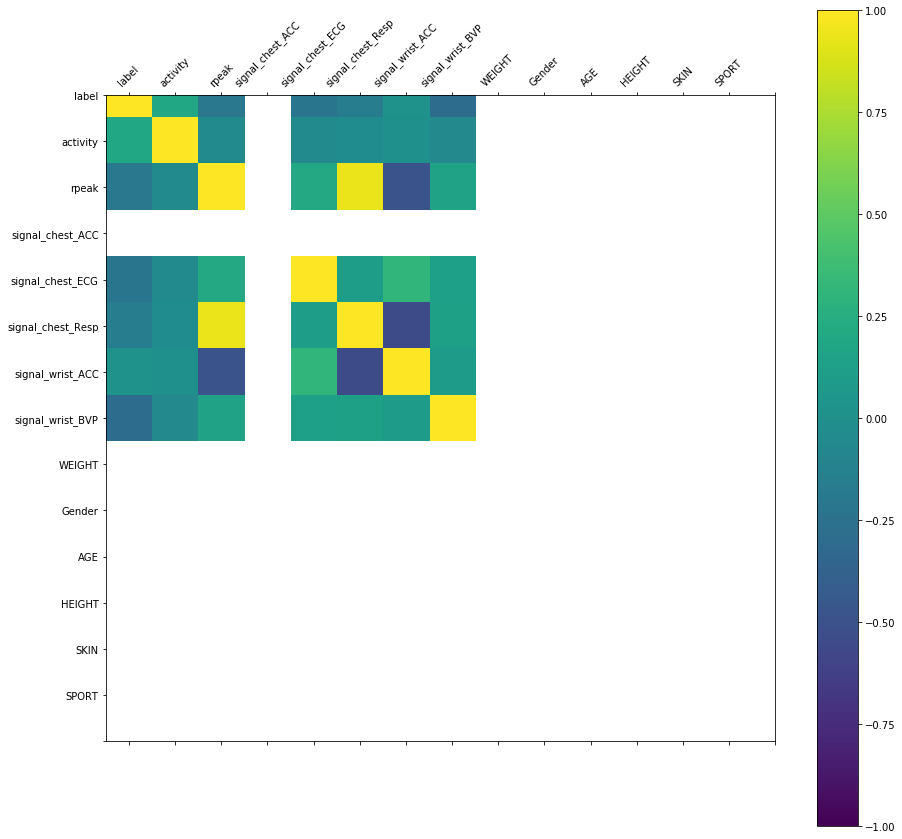

In [18]:
import matplotlib.pyplot as plt

correlations = full_df.corr()
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)

fig.colorbar(cax)
ticks = np.arange(0,15,1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(full_df.columns, rotation=45)
ax.set_yticklabels(full_df.columns)

plt.show()


## Creation de modèles

In [20]:
from sklearn.model_selection import train_test_split
y = full_df['activity']
x = full_df.drop(columns=['activity'])
feature = x.columns
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 92)

Arbre de décision

In [23]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=92)
tree.fit(x_train, y_train)

ValueError: setting an array element with a sequence.

In [ ]:
y_pred_tree = tree.predict(x_test)

In [25]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)

#
y_pred = lr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: setting an array element with a sequence.